In [98]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [99]:
#Import Dependencies

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

In [101]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [102]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\User\AppData\Local\Temp\ipykernel_25268\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [103]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [104]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [105]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [106]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_string = last_date[0]
latest_date = dt.datetime.strptime(latest_date_string, '%Y-%m-%d')

query_date = latest_date - dt.timedelta(days=365)
print (query_date)

2016-08-23 00:00:00


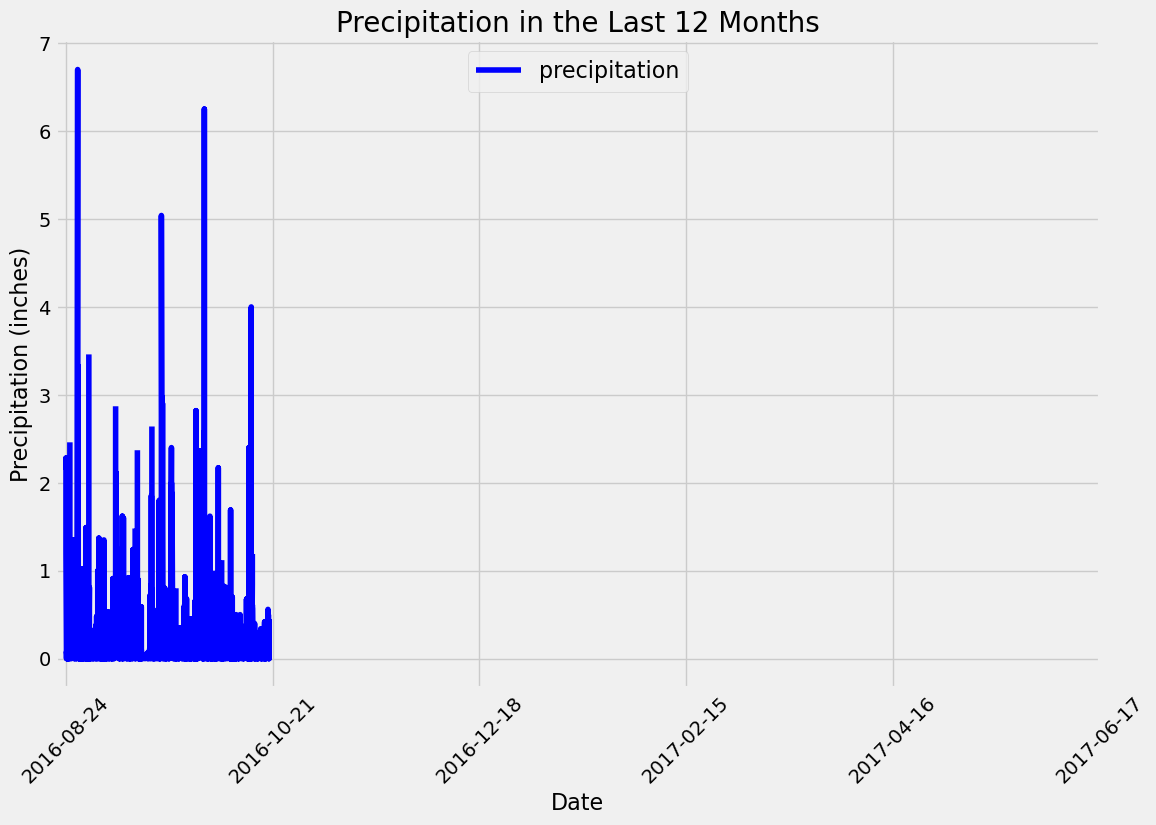

In [107]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
year_ago = last_date - dt.timedelta(days=365)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# create a DataFrame with the results
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# sort the DataFrame by date
df.sort_index(inplace=True)

# plot the precipitation data
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.index, df['precipitation'], color='b', label='precipitation')

# set plot title and labels
plt.title("Precipitation in the Last 12 Months", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Precipitation (inches)", fontsize=16)

# Convert index column to datetime object
df.index = pd.to_datetime(df.index)


# set x-tick labels
xtick_locs = np.arange(0, len(df), step=len(df)/6)
xtick_labels = [df.index[int(i)].strftime('%Y-%m-%d') for i in xtick_locs]
plt.xticks(xtick_locs, xtick_labels, rotation=45)

# add grid lines and legend
plt.grid(True)
plt.legend(loc='upper center', fontsize=16)

# show the plot
plt.show()

In [108]:
# calculate summary statistics for precipitation data
precipitation_stats = df['precipitation'].describe()

# print the summary statistics
print(precipitation_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [109]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()

# print the station count
print(station_count)

9


In [110]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()

# print the most active stations

for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_active_station).all()
print(temp_stats[0][0])
print(temp_stats[0][1])
print(temp_stats[0][2])

54.0
85.0
71.66378066378067


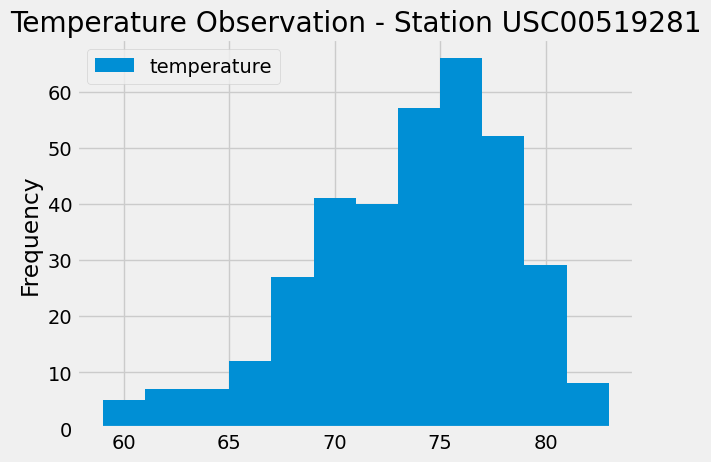

In [112]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = session.query(Measurement.tobs).\
               filter(Measurement.station == most_active_station).\
               filter(Measurement.date >= year_ago).all()

# convert the query results to a DataFrame and plot as a histogram
temp_df = pd.DataFrame(temp_results, columns=['temperature'])
temp_df.plot.hist(bins=12)
plt.ylabel("Frequency")
plt.title("Temperature Observation - Station " + most_active_station)
plt.show()

# Close Session

In [118]:
# Close Session
session.close()